In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
from astropy.table import Table

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
sdss = Table.read('/Users/james/Desktop/gaia_tmp/ssppOut-dr12.fits', format='fits')

xyok = np.where((sdss['RA'] >= 0) & (sdss['RA'] <= 360) & 
                (sdss['DEC'] >= -90) & (sdss['DEC'] <= 90))[0]
# df_out = pd.DataFrame(data={'ra':sdss['RA'][xyok], 'dec':sdss['DEC'][xyok]})
# df_out.to_csv('sspp_toX.csv')

Xgaia = pd.read_csv('/Users/james/Desktop/gaia_tmp/Xgaia.csv')
Xwise = pd.read_csv('/Users/james/Desktop/gaia_tmp/Xwise.csv')

df = sdss[xyok].to_pandas()
tmp_data = pd.merge(Xgaia, Xwise, left_on=u'id', right_on=u'id')
data = pd.merge(df, tmp_data, how='inner', left_on=np.arange(len(df)), right_on=u'id')

Text(0.5,1,'SSPP sources')

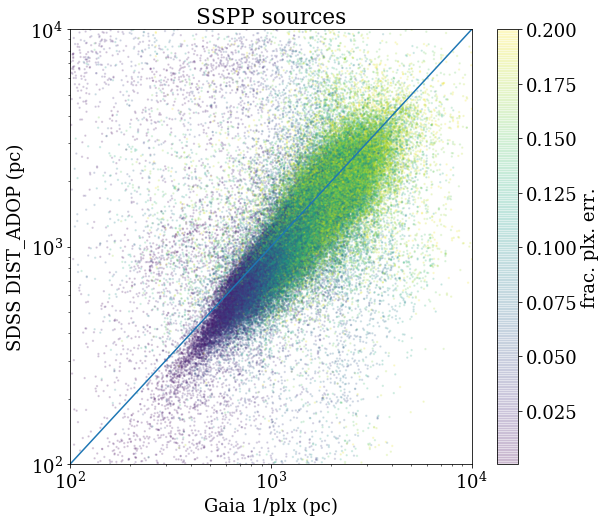

In [4]:
ok = np.where((data[u'parallax_error']/data[u'parallax'] <= 0.2) & 
              (data[u'parallax'] > 0))[0]

plt.figure(figsize=(9,8))
plt.scatter(1000./data[u'parallax'][ok], data[u'DIST_ADOP'][ok]*1000., s=2, alpha=0.15, 
            c=data[u'parallax_error'][ok]/data[u'parallax'][ok])
plt.xlabel('Gaia 1/plx (pc)')
plt.ylabel('SDSS DIST_ADOP (pc)')
plt.plot([1,1e4], [1,1e4])
cb = plt.colorbar()
cb.set_label('frac. plx. err.')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e2,1e4)
plt.xlim(1e2,1e4)
plt.title('SSPP sources')

Text(0,0.5,'b (deg)')

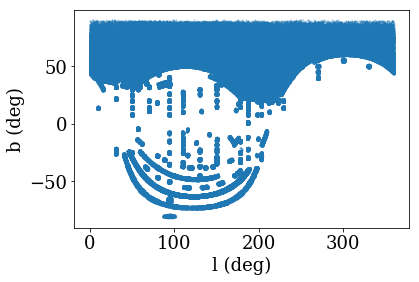

In [139]:
plt.scatter(data[u'L'], data[u'B'], s=1, alpha=0.3)
plt.xlabel('l (deg)')
plt.ylabel('b (deg)')

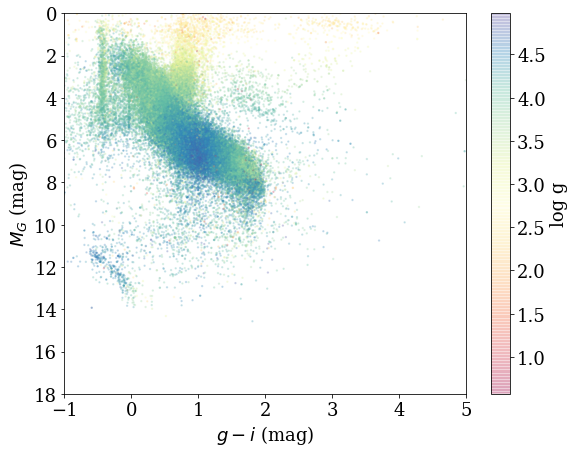

In [7]:
fok = np.where((data[u'FEH_ADOP'].values[ok] > -6))

M_G = (data[u'phot_g_mean_mag'].values[ok] - 
       5*np.log10(1000./data[u'parallax'].values[ok])+5)

plt.figure(figsize=(9,7))

plt.scatter(data[u'GR'].values[ok][fok]+data[u'RI'].values[ok][fok], 
            M_G[fok],
            s=2, alpha=0.2, c=data[u'LOGG_ADOP'].values[ok][fok], cmap=plt.cm.Spectral)

cb = plt.colorbar()
plt.ylim(18,0)
plt.xlim(-1,5)
plt.xlabel('$g-i$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
cb.set_label('log g')

In [9]:
gok = np.where((data[u'FEH_ADOP'].values[ok] > -6) & 
               (M_G > 4) & (M_G < 9) & 
               np.isfinite(data[u'a_g_val'].values[ok]) & 
               (data[u'a_g_val'].values[ok] < 0.5))



/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


Text(0.5,0,'$G-J$')

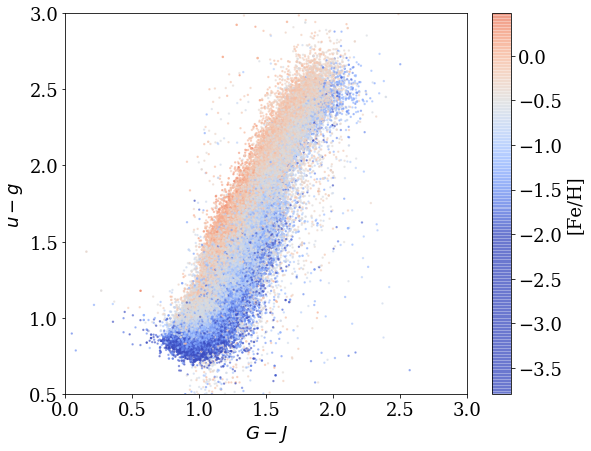

In [70]:
plt.figure(figsize=(9,7))
plt.scatter(data[u'phot_g_mean_mag'].values[ok][gok] - data[u'Jmag'].values[ok][gok], 
            data[u'UG'].values[ok][gok],
            c=data[u'FEH_ADOP'].values[ok][gok], s=2, alpha=0.5, cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim((-2,1))
plt.xlim(0,3)
plt.ylim(0.5,3)
plt.ylabel('$u-g$')
plt.xlabel('$G-J$')

In [11]:
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

In [12]:
vSun = [14.0, 12.24, 7.25] * u.km / u.s # (U, V, W) Schonrich+12
vrot = [0., 238., 0.] * u.km / u.s # Circular rotation velocity at Sun Position, Bland-hawthorn & Gerhard 2016

RSun = 8.2 * u.kpc # Bland-hawthorn & Gerhard 2016
zSun = 25. * u.pc  # Bland-hawthorn & Gerhard 2016

v_sun = coord.CartesianDifferential(vSun + vrot)
gc = coord.Galactocentric(galcen_distance=RSun, z_sun=zSun, galcen_v_sun=v_sun)

In [13]:
def get_vtot(ra, de, dist, pmra, pmde, vrad):

    # Inputs should be astropy quantities!

    icrs = coord.ICRS(ra=ra, dec=de, distance=dist, pm_ra_cosdec=pmra, pm_dec=pmde, radial_velocity=vrad)
    galC = icrs.transform_to(gc)

    U = galC.v_x
    V = galC.v_y
    W = galC.v_z
    vtot = np.sqrt(U**2. + V**2. + W**2.).to(u.km/u.s)

    xg = galC.x
    yg = galC.y
    zg = galC.z

    galC.representation = 'cylindrical'
    vR = galC.d_rho.to(u.km/u.s)

    return U, V, W, vtot, xg, yg, zg, vR

In [21]:
data.shape

(882766, 310)

In [114]:
pmok = np.where(np.isfinite(data[u'pmra'].values) & 
                (data[u'RV_ADOP_UNC'] > 0) & 
                (np.abs(data[u'RV_ADOP_UNC']/data[u'RV_ADOP']) < 0.1) & 
                (np.abs(data[u'RV_ADOP']) <= 600) &
                (np.abs(data[u'pmra_error']/data[u'pmra']) < 0.1) &
                (np.abs(data[u'pmdec_error']/data[u'pmdec']) < 0.1) &
                (data[u'parallax_error']/data[u'parallax'] <= 0.1) & 
                (data[u'parallax'] > 0)
               )
#                 (data[u'DIST_ADOP'] < 50) & 
#                 (data[u'DIST_ADOP'] > 0) &  


vtot = get_vtot(data[u'RA'].values[pmok] * u.deg, 
                data[u'DEC'].values[pmok] * u.deg, 
                1000./data[u'parallax'].values[pmok] * u.pc,
                data[u'pmra'].values[pmok] * u.mas/u.yr, 
                data[u'pmdec'].values[pmok] * u.mas/u.yr, 
                data[u'RV_ADOP'].values[pmok] * u.km/u.s)

Text(0,0.5,'# stars')

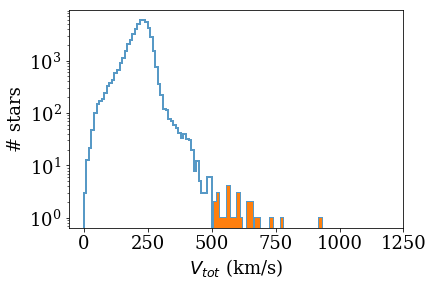

In [131]:
_ = plt.hist((vtot[3].value), histtype='step', bins=np.arange(0,1200,10), 
             lw=2, alpha=0.75)
_ = plt.hist((vtot[3].value), bins=np.arange(500,1200,10))
plt.yscale('log')
plt.xlabel(r'$V_{tot}$ (km/s)')
plt.ylabel('# stars')

In [126]:
sum(vtot[3].value > 900)

1

In [127]:
data[u'source_id'].values[pmok][vtot[3].value > 900]

array([1540013339194597376])

In [128]:
data[u'RV_ADOP'].values[pmok][vtot[3].value > 900]

array([-185.12416], dtype=float32)

In [129]:
data[u'RV_ADOP_UNC'].values[pmok][vtot[3].value > 900]

array([1.7377759], dtype=float32)

In [138]:
dfout = pd.DataFrame(data={'ra':data[u'RA'].values[pmok], 'dec':data[u'DEC'].values[pmok], 
                           'pmra':data[u'pmra'].values[pmok], 
                           'pmde':data[u'pmdec'].values[pmok], 
                           'e_pmra':data[u'pmra_error'].values[pmok], 
                           'e_pmde':data[u'pmdec_error'].values[pmok], 
                           'parallax':data[u'parallax'].values[pmok], 
                           'e_parallax':data[u'parallax_error'].values[pmok], 
                           'dist_adop':data[u'DIST_ADOP'].values[pmok], 
                           'rv_adop':data[u'RV_ADOP'].values[pmok], 
                           'rv_unc':data[u'RV_ADOP_UNC'].values[pmok], 
                           'gmag':data[u'phot_g_mean_mag'].values[pmok],
                           'source_id':data[u'source_id'].values[pmok]})
dfout.to_csv('davenport2tommaso.csv')

In [137]:
len(pmok[0])

51512